In [2]:
import numpy as np
import os

epsilon_data_path = os.path.join("data", "epsilon","raw", "data")

In [3]:
# read file in path
def read_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    return lines

In [4]:
data = read_file(epsilon_data_path)
print(data[0])

KeyboardInterrupt: 

In [5]:
def get_epsilon_sample(index, data):
    sample = data[index].strip().split()
    y = int(sample[0])
    x = [float(f.split(":")[1]) for f in sample[1:]]
    return np.array(x), y

In [6]:
for i, s in enumerate(data):
    # Save individual samples
    x, y = get_epsilon_sample(i, data)

    # Save the sample
    save_path = os.path.join("data", "epsilon", "samples", f"eps_{i}_{y}.obj")
    np.save(save_path, x) 
    pass


## Test Random Fourier

In [1]:
import torch
from random_fourier import RandomFourier
from dataset import EpsilonDataset
from constants import CONFIG, DEVICE
from utils import SPLIT

/home/rmazzieri/work/COURSES/MLComSys/mlcomsys_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_dataset = EpsilonDataset(config=CONFIG, split=SPLIT.TEST, client_idx=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

for X,y in test_dataloader:
    print(X.shape)
    break

torch.Size([256, 2000])


In [3]:
N = 10000
RF = RandomFourier(n_components=N)
RF.fit(X)
X2 = RF.transform(X)

In [4]:
print(X2.shape)

(256, 10000)


## How do I implement GIANT with Flower?
It seems that I can't actually simulate two communication rounds, as Flower automatically assumes that the configure_fit method will then upgrade the parameters of the network...

Probably I need to do everything on a single communication round. At round $t$:
1. [Client Side] Compute new local parameters from each client (indexed by $i$), then compute matrix $\mathbf{A_{t,i}}$. Send both to the server, together with number of local samples $s_i$.
2. [Server Side] Take the gradients and sum them to get $\mathbf{g}_t$.
3. [Server Side] For each client $j$, compute matrix $\mathbf{C}_{t,j} = (\frac{1}{s_j} \mathbf{A_{t,j}}^T \mathbf{A_{t,j}} + \gamma \mathbf{I}_d)$
4. [Server Side] For each client, solve this linear system (for $\mathbf{p}_j$) using Conjugate Gradient: $\mathbf{C}_{t,j} \mathbf{p}_j = \mathbf{g}_t$. The result is the ANT direction for client $j$. 
5. [Server Side] Compute average of all the ANT directions to get the final GIANT direction: $\mathbf{\tilde{p}}_t = \frac{1}{m} \sum_{i=1}^{m} \mathbf{p}_j$

# Final Plots

In [2]:
import pandas as pd
import os 
import matplotlib.pyplot as plt

In [3]:
# Set global plot settings
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 15,
    "hatch.linewidth": 0.0,
    "hatch.color": (0,0,0,0.0),
})

In [55]:
csvs_path = os.path.join("figures", "FinalPlots")

# Load csvs with the curves
train_accuracy_curves = pd.read_csv(os.path.join(csvs_path, "wandb_train_accuracy_curves.csv"))
valid_accuracy_curves = pd.read_csv(os.path.join(csvs_path, "wandb_valid_accuracy_curves.csv"))
train_loss_curves = pd.read_csv(os.path.join(csvs_path, "wandb_train_loss_curves.csv"))
valid_loss_curves = pd.read_csv(os.path.join(csvs_path, "wandb_valid_loss_curves.csv"))
valid_loss_byz = pd.read_csv(os.path.join(csvs_path, "wandb_valid_loss_byz.csv"))
valid_accuracy_byz = pd.read_csv(os.path.join(csvs_path, "wandb_valid_accuracy_byz.csv"))
loss_failed = pd.read_csv(os.path.join(csvs_path, "wandb_convergence_fail_loss.csv"))
accuracy_failed = pd.read_csv(os.path.join(csvs_path, "wandb_convergence_fail_accuracy.csv"))

mnm_loss_unif = pd.read_csv(os.path.join(csvs_path, "wandb_mnm_loss_unif.csv"))
mnm_accuracy_unif = pd.read_csv(os.path.join(csvs_path, "wandb_mnm_accuracy_unif.csv"))

valid_loss_curves.head()

,Step,GIANT_20C - Valid Loss,GIANT_20C - Valid Loss__MIN,GIANT_20C - Valid Loss__MAX,GIANT_20C_5A_MNM - Valid Loss,GIANT_20C_5A_MNM - Valid Loss__MIN,GIANT_20C_5A_MNM - Valid Loss__MAX,FedAvg_20C_5A - Valid Loss,FedAvg_20C_5A - Valid Loss__MIN,FedAvg_20C_5A - Valid Loss__MAX,GIANT_20C_5A - Valid Loss,GIANT_20C_5A - Valid Loss__MIN,GIANT_20C_5A - Valid Loss__MAX,FedAvg_20C - Valid Loss,FedAvg_20C - Valid Loss__MIN,FedAvg_20C - Valid Loss__MAX
0,0,0.693302,0.693302,0.693302,0.692991,0.692991,0.692991,0.693058,0.693058,0.693058,0.693171,0.693171,0.693171,0.692985,0.692985,0.692985
1,1,NaN,NaN,NaN,NaN,NaN,NaN,0.693058,0.693058,0.693058,NaN,NaN,NaN,0.673579,0.673579,0.673579
2,2,0.340409,0.340409,0.340409,0.375948,0.375948,0.375948,0.693058,0.693058,0.693058,0.697472,0.697472,0.697472,0.670948,0.670948,0.670948
3,3,NaN,NaN,NaN,NaN,NaN,NaN,0.693058,0.693058,0.693058,NaN,NaN,NaN,0.654888,0.654888,0.654888
4,4,0.281922,0.281922,0.281922,0.297911,0.297911,0.297911,0.693058,0.693058,0.693058,0.702048,0.702048,0.702048,0.652802,0.652802,0.652802


## GIANT vs FedAvg

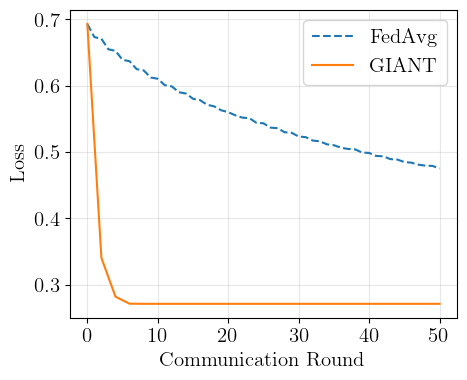

In [35]:
# Plot the validation loss curves of GIANT vs FedAvg
plt.figure(figsize=(5,4))
plt.plot(train_loss_curves.iloc[:,0], train_loss_curves.iloc[:,15], "--", label="FedAvg")
plt.plot(valid_loss_curves.iloc[:,0][::2], valid_loss_curves.iloc[:,1][::2], "-", label="GIANT")
plt.xlabel("Communication Round")
plt.ylabel("Loss")
plt.grid(alpha=0.3)

plt.legend()
plt.savefig(os.path.join(csvs_path, "GIANT_vs_FedAvg_loss.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(csvs_path, "GIANT_vs_FedAvg_loss.png"), bbox_inches="tight")
plt.show()

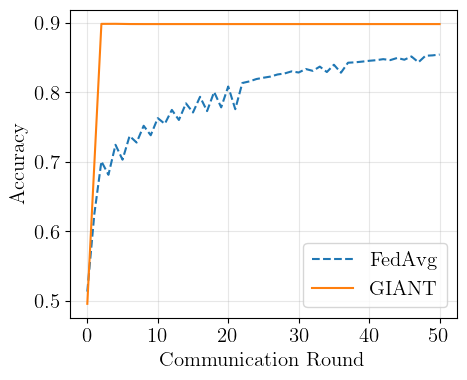

In [36]:
# Plot the validation accuracy curves of GIANT vs FedAvg
plt.figure(figsize=(5,4))
plt.plot(train_accuracy_curves.iloc[:,0], train_accuracy_curves.iloc[:,15], "--", label="FedAvg")
plt.plot(valid_accuracy_curves.iloc[:,0][::2], valid_accuracy_curves.iloc[:,1][::2], "-", label="GIANT")
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)

plt.legend()
plt.savefig(os.path.join(csvs_path, "GIANT_vs_FedAvg_accuracy.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(csvs_path, "GIANT_vs_FedAvg_accuracy.png"), bbox_inches="tight")
plt.show()

## MNM (Gaussian distrib)

In [25]:
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [48]:
valid_loss_byz.head(20)

,Step,GIANT_20C_11A_MNM - Valid Loss,GIANT_20C_11A_MNM - Valid Loss__MIN,GIANT_20C_11A_MNM - Valid Loss__MAX,GIANT_20C_9A_MNM - Valid Loss,GIANT_20C_9A_MNM - Valid Loss__MIN,GIANT_20C_9A_MNM - Valid Loss__MAX,GIANT_20C_7A_MNM - Valid Loss,GIANT_20C_7A_MNM - Valid Loss__MIN,GIANT_20C_7A_MNM - Valid Loss__MAX,GIANT_20C_3A_MNM - Valid Loss,GIANT_20C_3A_MNM - Valid Loss__MIN,GIANT_20C_3A_MNM - Valid Loss__MAX,GIANT_20C_5A_MNM - Valid Loss,GIANT_20C_5A_MNM - Valid Loss__MIN,GIANT_20C_5A_MNM - Valid Loss__MAX
0,0,0.693296,0.693296,0.693296,0.692946,0.692946,0.692946,0.693190,0.693190,0.693190,0.693164,0.693164,0.693164,0.692991,0.692991,0.692991
1,2,0.557476,0.557476,0.557476,0.432055,0.432055,0.432055,0.397109,0.397109,0.397109,0.359139,0.359139,0.359139,0.375948,0.375948,0.375948
2,4,0.472320,0.472320,0.472320,0.333775,0.333775,0.333775,0.311792,0.311792,0.311792,0.290024,0.290024,0.290024,0.297911,0.297911,0.297911
3,6,0.414947,0.414947,0.414947,0.293742,0.293742,0.293742,0.284858,0.284858,0.284858,0.274659,0.274659,0.274659,0.278011,0.278011,0.278011
4,8,0.367503,0.367503,0.367503,0.283676,0.283676,0.283676,0.282588,0.282588,0.282588,0.274019,0.274019,0.274019,0.276747,0.276747,0.276747
5,10,0.336051,0.336051,0.336051,0.281587,0.281587,0.281587,0.280698,0.280698,0.280698,0.273440,0.273440,0.273440,0.275701,0.275701,0.275701
6,12,0.318671,0.318671,0.318671,0.280131,0.280131,0.280131,0.278971,0.278971,0.278971,0.273067,0.273067,0.273067,0.274933,0.274933,0.274933
7,14,0.304695,0.304695,0.304695,0.278689,0.278689,0.278689,0.277653,0.277653,0.277653,0.272619,0.272619,0.272619,0.274255,0.274255,0.274255
8,16,0.295248,0.295248,0.295248,0.277441,0.277441,0.277441,0.276628,0.276628,0.276628,0.272335,0.272335,0.272335,0.273625,0.273625,0.273625
9,18,0.288938,0.288938,0.288938,0.276419,0.276419,0.276419,0.275684,0.275684,0.275684,0.272144,0.272144,0.272144,0.273172,0.273172,0.273172


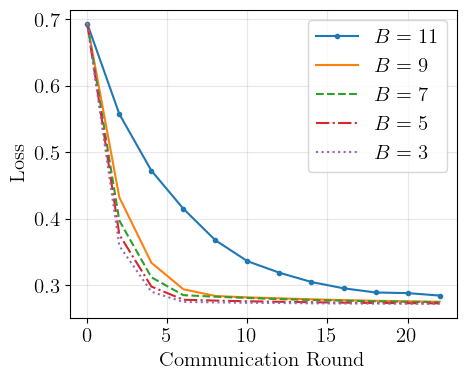

In [49]:
# Plot the validation loss curves of GIANT for different numbers of Byzantine attackers

# At row 8, column 1, put the value of 0.3
# valid_loss_byz.iloc[8,1] = 0.3

n_to_show=12

plt.figure(figsize=(5,4))
plt.plot(valid_loss_byz.iloc[:,0][:n_to_show], valid_loss_byz.iloc[:,1][:n_to_show], ".-", label="$B = 11$")
plt.plot(valid_loss_byz.iloc[:,0][:n_to_show], valid_loss_byz.iloc[:,4][:n_to_show], "-", label="$B = 9$")
plt.plot(valid_loss_byz.iloc[:,0][:n_to_show], valid_loss_byz.iloc[:,7][:n_to_show], "--", label="$B = 7$")
plt.plot(valid_loss_byz.iloc[:,0][:n_to_show], valid_loss_byz.iloc[:,13][:n_to_show],"-.", label="$B = 5$")
plt.plot(valid_loss_byz.iloc[:,0][:n_to_show], valid_loss_byz.iloc[:,10][:n_to_show], ":", label="$B = 3$")
plt.grid(alpha=0.3)
plt.xlabel("Communication Round")
plt.ylabel("Loss")
plt.legend()

plt.savefig(os.path.join(csvs_path, "GIANT_byz_loss.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(csvs_path, "GIANT_byz_loss.png"), bbox_inches="tight")

plt.show()




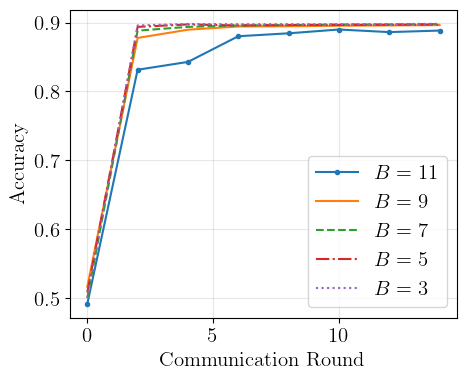

In [50]:
# Plot the validation accuracy curves of GIANT for different numbers of Byzantine attackers
n_start = 0
n_to_show=8

plt.figure(figsize=(5,4))
plt.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,1][n_start:n_to_show], ".-", label="$B = 11$")
plt.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,4][n_start:n_to_show], "-", label="$B = 9$")
plt.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,7][n_start:n_to_show], "--", label="$B = 7$")
plt.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,13][n_start:n_to_show],"-.", label="$B = 5$")
plt.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,10][n_start:n_to_show], ":", label="$B = 3$")
plt.grid(alpha=0.3)
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.legend()

plt.savefig(os.path.join(csvs_path, "GIANT_byz_acc.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(csvs_path, "GIANT_byz_acc.png"), bbox_inches="tight")

plt.show()

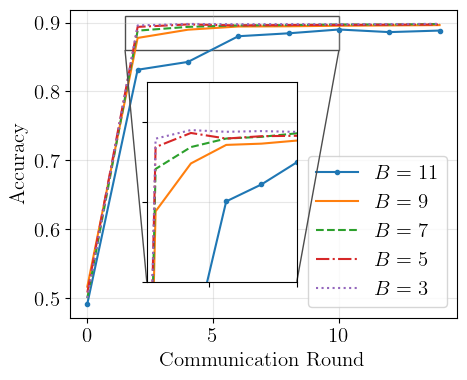

In [54]:
# another version of the previous plot where i create a zoomed region for the first rounds, 
# to better show the differences
n_start = 0
n_to_show=8

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,1][n_start:n_to_show], ".-", label="$B = 11$")
ax.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,4][n_start:n_to_show], "-", label="$B = 9$")
ax.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,7][n_start:n_to_show], "--", label="$B = 7$")
ax.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,13][n_start:n_to_show],"-.", label="$B = 5$")
ax.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,10][n_start:n_to_show], ":", label="$B = 3$")
ax.grid(alpha=0.3)
ax.set_xlabel("Communication Round")
ax.set_ylabel("Accuracy")
ax.legend()


# Create a zoomed region for the first rounds
# axins = zoomed_inset_axes(ax, 3, loc=5)
axins = inset_axes(ax, 1.5, 2, loc=5, bbox_to_anchor=(0.6, 0.45), bbox_transform=ax.figure.transFigure)
axins.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,1][n_start:n_to_show], ".-", label="$B = 11$")
axins.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,4][n_start:n_to_show], "-", label="$B = 9$")
axins.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,7][n_start:n_to_show], "--", label="$B = 7$")
axins.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,13][n_start:n_to_show],"-.", label="$B = 5$")
axins.plot(valid_accuracy_byz.iloc[:,0][n_start:n_to_show], valid_accuracy_byz.iloc[:,10][n_start:n_to_show], ":", label="$B = 3$")
axins.grid(alpha=0.3)


x1, x2, y1, y2 = 1.5, 10, 0.86, .91
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)

mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.3")

plt.savefig(os.path.join(csvs_path, "GIANT_byz_acc_zoom.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(csvs_path, "GIANT_byz_acc_zoom.png"), bbox_inches="tight")

plt.show()


## MNM (Uniform distrib)

In [57]:
mnm_loss_unif.head(12)

,Step,GIANT_20C_11A_MNM_unif - Valid Loss,GIANT_20C_11A_MNM_unif - Valid Loss__MIN,GIANT_20C_11A_MNM_unif - Valid Loss__MAX,GIANT_20C_9A_MNM_unif - Valid Loss,GIANT_20C_9A_MNM_unif - Valid Loss__MIN,GIANT_20C_9A_MNM_unif - Valid Loss__MAX,GIANT_20C_5A_MNM_unif - Valid Loss,GIANT_20C_5A_MNM_unif - Valid Loss__MIN,GIANT_20C_5A_MNM_unif - Valid Loss__MAX,GIANT_20C_7A_MNM_unif - Valid Loss,GIANT_20C_7A_MNM_unif - Valid Loss__MIN,GIANT_20C_7A_MNM_unif - Valid Loss__MAX,GIANT_20C_3A_MNM_unif - Valid Loss,GIANT_20C_3A_MNM_unif - Valid Loss__MIN,GIANT_20C_3A_MNM_unif - Valid Loss__MAX
0,0,0.693139,0.693139,0.693139,0.693427,0.693427,0.693427,0.693274,0.693274,0.693274,0.693271,0.693271,0.693271,0.693270,0.693270,0.693270
1,2,0.693139,0.693139,0.693139,0.572232,0.572232,0.572232,0.380947,0.380947,0.380947,0.424889,0.424889,0.424889,0.361189,0.361189,0.361189
2,4,0.693139,0.693139,0.693139,0.568548,0.568548,0.568548,0.312708,0.312708,0.312708,0.361471,0.361471,0.361471,0.293025,0.293025,0.293025
3,6,0.693138,0.693138,0.693138,0.564124,0.564124,0.564124,0.294574,0.294574,0.294574,0.341040,0.341040,0.341040,0.277852,0.277852,0.277852
4,8,0.693139,0.693139,0.693139,0.561743,0.561743,0.561743,0.293982,0.293982,0.293982,0.341040,0.341040,0.341040,0.277220,0.277220,0.277220
5,10,0.693139,0.693139,0.693139,0.558796,0.558796,0.558796,0.292081,0.292081,0.292081,0.340682,0.340682,0.340682,0.277054,0.277054,0.277054
6,12,NaN,NaN,NaN,0.558797,0.558797,0.558797,0.291633,0.291633,0.291633,0.339851,0.339851,0.339851,0.276820,0.276820,0.276820
7,14,NaN,NaN,NaN,0.558798,0.558798,0.558798,0.291485,0.291485,0.291485,0.339851,0.339851,0.339851,0.276619,0.276619,0.276619
8,16,NaN,NaN,NaN,0.558797,0.558797,0.558797,0.291338,0.291338,0.291338,0.339558,0.339558,0.339558,0.276462,0.276462,0.276462
9,18,NaN,NaN,NaN,0.558795,0.558795,0.558795,0.291030,0.291030,0.291030,0.339174,0.339174,0.339174,0.276338,0.276338,0.276338


In [75]:
# Fill the missing values in column 1 from row 6 to 11 with the value 0.6931
mnm_loss_unif.iloc[6:12,1] = 0.6931

mnm_loss_unif.head(12)

,Step,GIANT_20C_11A_MNM_unif - Valid Loss,GIANT_20C_11A_MNM_unif - Valid Loss__MIN,GIANT_20C_11A_MNM_unif - Valid Loss__MAX,GIANT_20C_9A_MNM_unif - Valid Loss,GIANT_20C_9A_MNM_unif - Valid Loss__MIN,GIANT_20C_9A_MNM_unif - Valid Loss__MAX,GIANT_20C_5A_MNM_unif - Valid Loss,GIANT_20C_5A_MNM_unif - Valid Loss__MIN,GIANT_20C_5A_MNM_unif - Valid Loss__MAX,GIANT_20C_7A_MNM_unif - Valid Loss,GIANT_20C_7A_MNM_unif - Valid Loss__MIN,GIANT_20C_7A_MNM_unif - Valid Loss__MAX,GIANT_20C_3A_MNM_unif - Valid Loss,GIANT_20C_3A_MNM_unif - Valid Loss__MIN,GIANT_20C_3A_MNM_unif - Valid Loss__MAX
0,0,0.693139,0.693139,0.693139,0.693427,0.693427,0.693427,0.693274,0.693274,0.693274,0.693271,0.693271,0.693271,0.693270,0.693270,0.693270
1,2,0.693139,0.693139,0.693139,0.572232,0.572232,0.572232,0.380947,0.380947,0.380947,0.424889,0.424889,0.424889,0.361189,0.361189,0.361189
2,4,0.693139,0.693139,0.693139,0.568548,0.568548,0.568548,0.312708,0.312708,0.312708,0.361471,0.361471,0.361471,0.293025,0.293025,0.293025
3,6,0.693138,0.693138,0.693138,0.564124,0.564124,0.564124,0.294574,0.294574,0.294574,0.341040,0.341040,0.341040,0.277852,0.277852,0.277852
4,8,0.693139,0.693139,0.693139,0.561743,0.561743,0.561743,0.293982,0.293982,0.293982,0.341040,0.341040,0.341040,0.277220,0.277220,0.277220
5,10,0.693139,0.693139,0.693139,0.558796,0.558796,0.558796,0.292081,0.292081,0.292081,0.340682,0.340682,0.340682,0.277054,0.277054,0.277054
6,12,0.693100,NaN,NaN,0.558797,0.558797,0.558797,0.291633,0.291633,0.291633,0.339851,0.339851,0.339851,0.276820,0.276820,0.276820
7,14,0.693100,NaN,NaN,0.558798,0.558798,0.558798,0.291485,0.291485,0.291485,0.339851,0.339851,0.339851,0.276619,0.276619,0.276619
8,16,0.693100,NaN,NaN,0.558797,0.558797,0.558797,0.291338,0.291338,0.291338,0.339558,0.339558,0.339558,0.276462,0.276462,0.276462
9,18,0.693100,NaN,NaN,0.558795,0.558795,0.558795,0.291030,0.291030,0.291030,0.339174,0.339174,0.339174,0.276338,0.276338,0.276338


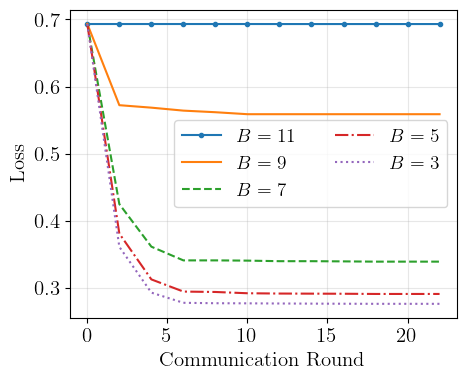

In [80]:
# Same plot above, but using mnm_loss_unif
n_to_show=12

plt.figure(figsize=(5,4))
plt.plot(mnm_loss_unif.iloc[:,0][:n_to_show], mnm_loss_unif.iloc[:,1][:n_to_show], ".-", label="$B = 11$")
plt.plot(mnm_loss_unif.iloc[:,0][:n_to_show], mnm_loss_unif.iloc[:,4][:n_to_show], "-", label="$B = 9$")
plt.plot(mnm_loss_unif.iloc[:,0][:n_to_show], mnm_loss_unif.iloc[:,10][:n_to_show], "--", label="$B = 7$")
plt.plot(mnm_loss_unif.iloc[:,0][:n_to_show], mnm_loss_unif.iloc[:,7][:n_to_show],"-.", label="$B = 5$")
plt.plot(mnm_loss_unif.iloc[:,0][:n_to_show], mnm_loss_unif.iloc[:,13][:n_to_show], ":", label="$B = 3$")
plt.grid(alpha=0.3)

plt.xlabel("Communication Round")
plt.ylabel("Loss")

# put the legend in two columns and smaller font
plt.legend(ncol=2, fontsize=14)
plt.savefig(os.path.join(csvs_path, "MNM_byz_unif_loss.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(csvs_path, "MNM_byz_unif_loss.png"), bbox_inches="tight")

plt.show()

In [77]:
mnm_accuracy_unif.head(12)

,Step,GIANT_20C_11A_MNM_unif - Valid Accuracy,GIANT_20C_11A_MNM_unif - Valid Accuracy__MIN,GIANT_20C_11A_MNM_unif - Valid Accuracy__MAX,GIANT_20C_9A_MNM_unif - Valid Accuracy,GIANT_20C_9A_MNM_unif - Valid Accuracy__MIN,GIANT_20C_9A_MNM_unif - Valid Accuracy__MAX,GIANT_20C_5A_MNM_unif - Valid Accuracy,GIANT_20C_5A_MNM_unif - Valid Accuracy__MIN,GIANT_20C_5A_MNM_unif - Valid Accuracy__MAX,GIANT_20C_7A_MNM_unif - Valid Accuracy,GIANT_20C_7A_MNM_unif - Valid Accuracy__MIN,GIANT_20C_7A_MNM_unif - Valid Accuracy__MAX,GIANT_20C_3A_MNM_unif - Valid Accuracy,GIANT_20C_3A_MNM_unif - Valid Accuracy__MIN,GIANT_20C_3A_MNM_unif - Valid Accuracy__MAX
0,0,0.501159,0.501159,0.501159,0.483342,0.483342,0.483342,0.494229,0.494229,0.494229,0.494279,0.494279,0.494279,0.491104,0.491104,0.491104
1,2,0.501096,0.501096,0.501096,0.778679,0.778679,0.778679,0.881590,0.881590,0.881590,0.853944,0.853944,0.853944,0.892301,0.892301,0.892301
2,4,0.501159,0.501159,0.501159,0.782661,0.782661,0.782661,0.887840,0.887840,0.887840,0.868460,0.868460,0.868460,0.895413,0.895413,0.895413
3,6,0.501147,0.501147,0.501147,0.786694,0.786694,0.786694,0.890663,0.890663,0.890663,0.876638,0.876638,0.876638,0.895728,0.895728,0.895728
4,8,0.501210,0.501210,0.501210,0.790335,0.790335,0.790335,0.891129,0.891129,0.891129,0.876638,0.876638,0.876638,0.895905,0.895905,0.895905
5,10,0.501184,0.501184,0.501184,0.794292,0.794292,0.794292,0.891305,0.891305,0.891305,0.877130,0.877130,0.877130,0.896056,0.896056,0.896056
6,12,0.501100,NaN,NaN,0.794292,0.794292,0.794292,0.891457,0.891457,0.891457,0.877734,0.877734,0.877734,0.896472,0.896472,0.896472
7,14,0.501100,NaN,NaN,0.794292,0.794292,0.794292,0.891557,0.891557,0.891557,0.877747,0.877747,0.877747,0.896283,0.896283,0.896283
8,16,0.501100,NaN,NaN,0.794292,0.794292,0.794292,0.891772,0.891772,0.891772,0.878049,0.878049,0.878049,0.896258,0.896258,0.896258
9,18,0.501100,NaN,NaN,0.794292,0.794292,0.794292,0.891759,0.891759,0.891759,0.878591,0.878591,0.878591,0.896409,0.896409,0.896409


In [73]:
mnm_accuracy_unif.iloc[6:12,1] = 0.5011

mnm_accuracy_unif.head(12)

,Step,GIANT_20C_11A_MNM_unif - Valid Accuracy,GIANT_20C_11A_MNM_unif - Valid Accuracy__MIN,GIANT_20C_11A_MNM_unif - Valid Accuracy__MAX,GIANT_20C_9A_MNM_unif - Valid Accuracy,GIANT_20C_9A_MNM_unif - Valid Accuracy__MIN,GIANT_20C_9A_MNM_unif - Valid Accuracy__MAX,GIANT_20C_5A_MNM_unif - Valid Accuracy,GIANT_20C_5A_MNM_unif - Valid Accuracy__MIN,GIANT_20C_5A_MNM_unif - Valid Accuracy__MAX,GIANT_20C_7A_MNM_unif - Valid Accuracy,GIANT_20C_7A_MNM_unif - Valid Accuracy__MIN,GIANT_20C_7A_MNM_unif - Valid Accuracy__MAX,GIANT_20C_3A_MNM_unif - Valid Accuracy,GIANT_20C_3A_MNM_unif - Valid Accuracy__MIN,GIANT_20C_3A_MNM_unif - Valid Accuracy__MAX
0,0,0.501159,0.501159,0.501159,0.483342,0.483342,0.483342,0.494229,0.494229,0.494229,0.494279,0.494279,0.494279,0.491104,0.491104,0.491104
1,2,0.501096,0.501096,0.501096,0.778679,0.778679,0.778679,0.881590,0.881590,0.881590,0.853944,0.853944,0.853944,0.892301,0.892301,0.892301
2,4,0.501159,0.501159,0.501159,0.782661,0.782661,0.782661,0.887840,0.887840,0.887840,0.868460,0.868460,0.868460,0.895413,0.895413,0.895413
3,6,0.501147,0.501147,0.501147,0.786694,0.786694,0.786694,0.890663,0.890663,0.890663,0.876638,0.876638,0.876638,0.895728,0.895728,0.895728
4,8,0.501210,0.501210,0.501210,0.790335,0.790335,0.790335,0.891129,0.891129,0.891129,0.876638,0.876638,0.876638,0.895905,0.895905,0.895905
5,10,0.501184,0.501184,0.501184,0.794292,0.794292,0.794292,0.891305,0.891305,0.891305,0.877130,0.877130,0.877130,0.896056,0.896056,0.896056
6,12,0.501100,NaN,NaN,0.794292,0.794292,0.794292,0.891457,0.891457,0.891457,0.877734,0.877734,0.877734,0.896472,0.896472,0.896472
7,14,0.501100,NaN,NaN,0.794292,0.794292,0.794292,0.891557,0.891557,0.891557,0.877747,0.877747,0.877747,0.896283,0.896283,0.896283
8,16,0.501100,NaN,NaN,0.794292,0.794292,0.794292,0.891772,0.891772,0.891772,0.878049,0.878049,0.878049,0.896258,0.896258,0.896258
9,18,0.501100,NaN,NaN,0.794292,0.794292,0.794292,0.891759,0.891759,0.891759,0.878591,0.878591,0.878591,0.896409,0.896409,0.896409


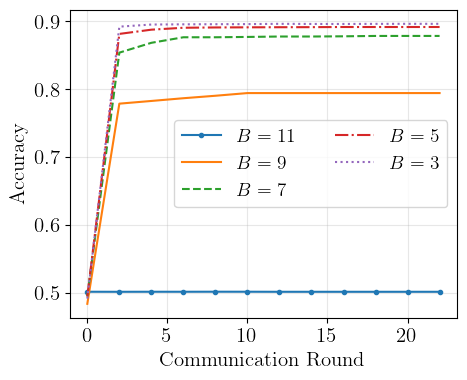

In [79]:
# Same plot above, but using mnm_accuracy_unif
n_to_show=12

plt.figure(figsize=(5,4))
plt.plot(mnm_accuracy_unif.iloc[:,0][:n_to_show], mnm_accuracy_unif.iloc[:,1][:n_to_show], ".-", label="$B = 11$")
plt.plot(mnm_accuracy_unif.iloc[:,0][:n_to_show], mnm_accuracy_unif.iloc[:,4][:n_to_show], "-", label="$B = 9$")
plt.plot(mnm_accuracy_unif.iloc[:,0][:n_to_show], mnm_accuracy_unif.iloc[:,10][:n_to_show], "--", label="$B = 7$")
plt.plot(mnm_accuracy_unif.iloc[:,0][:n_to_show], mnm_accuracy_unif.iloc[:,7][:n_to_show],"-.", label="$B = 5$")
plt.plot(mnm_accuracy_unif.iloc[:,0][:n_to_show], mnm_accuracy_unif.iloc[:,13][:n_to_show], ":", label="$B = 3$")
plt.grid(alpha=0.3)

plt.xlabel("Communication Round")
plt.ylabel("Accuracy")

# put the legend in two columns and smaller font
plt.legend(ncol=2, fontsize=14)
plt.savefig(os.path.join(csvs_path, "MNM_byz_unif_acc.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(csvs_path, "MNM_byz_unif_acc.png"), bbox_inches="tight")

plt.show()


## Failure to converge with attackers

In [7]:
## Plot the convergence failure of GIANT and FedAvg when byzantine attackers are present
loss_failed.head()

,Step,GIANT_20C_5A_MNM - Valid Loss,GIANT_20C_5A_MNM - Valid Loss__MIN,GIANT_20C_5A_MNM - Valid Loss__MAX,FedAvg_20C_5A - Valid Loss,FedAvg_20C_5A - Valid Loss__MIN,FedAvg_20C_5A - Valid Loss__MAX,GIANT_20C_5A - Valid Loss,GIANT_20C_5A - Valid Loss__MIN,GIANT_20C_5A - Valid Loss__MAX
0,0,0.692991,0.692991,0.692991,0.693058,0.693058,0.693058,0.693171,0.693171,0.693171
1,1,NaN,NaN,NaN,0.693058,0.693058,0.693058,NaN,NaN,NaN
2,2,0.375948,0.375948,0.375948,0.693058,0.693058,0.693058,0.697472,0.697472,0.697472
3,3,NaN,NaN,NaN,0.693058,0.693058,0.693058,NaN,NaN,NaN
4,4,0.297911,0.297911,0.297911,0.693058,0.693058,0.693058,0.702048,0.702048,0.702048


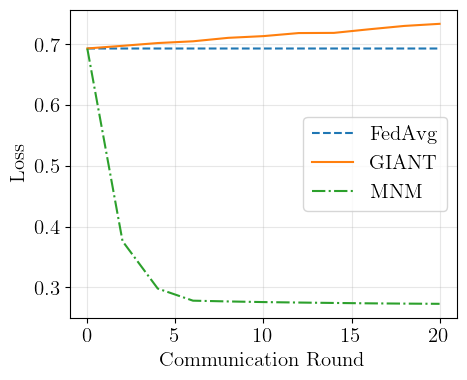

In [33]:
## Plot the convergence failure of GIANT and FedAvg when byzantine attackers are present

to_show = 11

plt.figure(figsize=(5,4))
plt.plot(loss_failed.iloc[:,0][:to_show*2-1], loss_failed.iloc[:,4][:to_show*2-1],      "--", label="FedAvg")
plt.plot(loss_failed.iloc[:,0][::2][:to_show], loss_failed.iloc[:,7][::2][:to_show],    "-", label="GIANT")
plt.plot(loss_failed.iloc[:,0][::2][:to_show], loss_failed.iloc[:,1][::2][:to_show],    "-.", label="MNM")
plt.xlabel("Communication Round")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()

plt.savefig(os.path.join(csvs_path, "GIANT_FedAvg_convergence_loss_fail.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(csvs_path, "GIANT_FedAvg_convergence_loss_fail.png"), bbox_inches="tight")

plt.show()

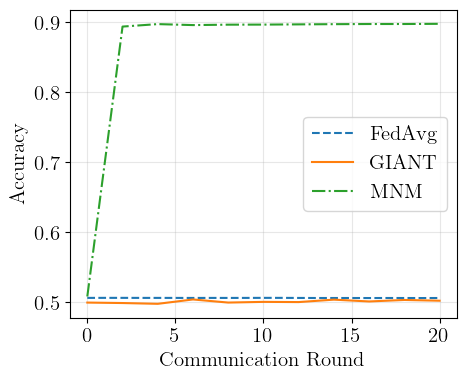

In [34]:
## The same plot but for accuracy

to_show = 11

plt.figure(figsize=(5,4))
plt.plot(accuracy_failed.iloc[:,0][:to_show*2-1], accuracy_failed.iloc[:,4][:to_show*2-1],      "--", label="FedAvg")
plt.plot(accuracy_failed.iloc[:,0][::2][:to_show], accuracy_failed.iloc[:,7][::2][:to_show],    "-",  label="GIANT")
plt.plot(accuracy_failed.iloc[:,0][::2][:to_show], accuracy_failed.iloc[:,1][::2][:to_show],    "-.",  label="MNM")
plt.xlabel("Communication Round")

plt.ylabel("Accuracy")
plt.grid(alpha=0.3)
plt.legend()

plt.savefig(os.path.join(csvs_path, "GIANT_FedAvg_convergence_accuracy_fail.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(csvs_path, "GIANT_FedAvg_convergence_accuracy_fail.png"), bbox_inches="tight")

plt.show()